## Install Packages for the Environment via Anaconda

Follow these steps to install new packages:

1. **Activate the Environment**  
   After creating the environment, activate it using:  
   **`conda activate ErSE222`**

2. **Install ipywidgets**  
   Once the environment is activated, install ipywidgets with:  
   **`pip install ipywidgets`**  
   *Usage*: Provides interactive HTML widgets for Jupyter notebooks, enabling dynamic visualizations and user interfaces.

3. **Install tqdm**  
   After activating the environment, install tqdm with:  
   **`pip install tqdm`**  
   *Usage*: A fast, extensible progress bar for Python, allowing users to visualize the progress of loops or operations.

4. **Install seaborn**  
   After activating the environment, install seaborn with:  
   **`pip install seaborn`**  
   *Usage*: A statistical data visualization library based on Matplotlib, designed for creating informative and attractive graphics.

5. **Install scikit-learn**  
   Install scikit-learn with:  
   **`pip install scikit-learn`**  
   *Usage*: A comprehensive machine learning library for Python that provides tools for data mining and data analysis. It includes various algorithms for classification, regression, clustering, and dimensionality reduction, as well as utilities for model evaluation and preprocessing.






## Using GPUs
PyTorch also provides a GPU backend. Provided we have access to a GPU, let's see how we can move our tensors from the CPU to the GPU and back.

The conversion of tensors to numpy require the tensor to be on the CPU, and not the GPU (more on GPU support in a later section). In case you have a tensor on GPU, you need to call `.cpu()` on the tensor beforehand. Hence, you get a line like `np_arr = tensor.cpu().numpy()`.

So, let's start with importing PyTorch. The package is called torch, based on its original framework Torch. As a first step, we can check its version:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)


gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [2]:
# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


In [3]:
import time
import torch

x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 0.13792s
GPU time: 0.00968s


Depending on the size of the operation and the CPU/GPU in your system, the speedup of this operation can be >50x. As `matmul` operations are very common in neural networks, we can already see the great benefit of training a NN on a GPU. The time estimate can be relatively noisy here because we haven't run it for multiple times. Feel free to extend this, but it also takes longer to run.

When generating random numbers, the seed between CPU and GPU is not synchronized. Hence, we need to set the seed on the GPU separately to ensure a reproducible code. Note that due to different GPU architectures, running the same code on different GPUs does not guarantee the same random numbers. Still, we don't want that our code gives us a different output every time we run it on the exact same hardware. Hence, we also set the seed on the GPU:

## Pytorch Autograd

With PyTorch you can write any sequence of operations on a Tensor. As long as these are all PyTorch operations, PyTorch will create a computational graph which we can always traverse back to obtain the derivative of such a sequence of operations.

Let's consider the following function:
$$
f(x) = sin(\pi x)
$$

We know that its derivative is:

$$
f'(x) = \pi cos(\pi x)
$$

So for $x=1$, we should expect $f(x)=0$ and $f'(x) = -\pi$.

In [4]:
import numpy as np
# Input
x = torch.ones(1, requires_grad=True)
# Output
y = torch.sin(x * np.pi)

grad = torch.autograd.grad(y, x)[0].item()
print(f'The derivative of y is: {grad}')

The derivative of y is: -3.1415927410125732


### Simple Linear Regression Basics
- Allows us to understand **relationship** between two **continuous variables**
- Example
    - x: independent variable
        - weight
    - y: dependent variable
        - height
- $y = W x + b$

### Aim of Linear Regression
- Minimize the distance between the points and the line ($y = W x + b$)
- Adjusting
    - Coefficient: $W$
    - Bias/intercept: $b$

## Building a Linear Regression Model with PyTorch

### Example
- Coefficient: $W = 2$
- Bias/intercept: $b = 1$
- Equation: $y = 2x + 1$

## Create the true values for training


In [5]:
# Input 
x = [i for i in range(11)]
# Target
y = [2*i + 1 for i in x]

# Convert to tensor
x = np.array(x,dtype=np.float32)
y = np.array(y,dtype=np.float32)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

x = torch.from_numpy(x).requires_grad_()
y = torch.from_numpy(y)

print("x_values:",x)
print("y_values:",y)

x_values: tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]], requires_grad=True)
y_values: tensor([[ 1.],
        [ 3.],
        [ 5.],
        [ 7.],
        [ 9.],
        [11.],
        [13.],
        [15.],
        [17.],
        [19.],
        [21.]])


**Create Model**
1. Linear model
    - True Equation: $y = 2x + 1$
2. Forward
    - Example
        - Input $x = 1 $
        - Output $\hat y = ?$

In [6]:
import torch
import torch.nn as nn
import numpy as np

'''
STEP 1: CREATE MODEL CLASS
'''
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  # Wx + b
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
'''
STEP 2: INSTANTIATE MODEL CLASS
'''
input_dim = 1
output_dim = 1

model = LinearRegressionModel(input_dim, output_dim)


#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

**Instantiate Loss Class**
- MSE Loss: Mean Squared Error
- $MSE = \frac{1}{n} \sum_{i=1}^n(\hat y_i - y_i)$
    - $\hat y$: prediction
    - $y$: true value

In [8]:
'''
STEP 3: INSTANTIATE LOSS CLASS
'''

criterion = nn.MSELoss()

**Instantiate Optimizer Class**
- Simplified equation
    - $\theta = \theta - \eta \cdot \nabla_\theta $
        - $\theta$: parameters (our variables)
        - $\eta$: learning rate (how fast we want to learn)
        - $\nabla_\theta$: parameters' gradients
- Even simplier equation
    - `parameters = parameters - learning_rate * parameters_gradients`
        - parameters: $W$ and $b$ in $ y = W x + $b
        - desired parameters: $W = 2$ and $b = 1$ in $ y = 2x + 1$

In [9]:
'''
STEP 4: INSTANTIATE OPTIMIZER CLASS
'''

learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

**Train Model**
- 1 epoch: going through the whole x_train data once
    - 100 epochs: 
        - 100x mapping `x_train = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`
        
- Process 
    1. Convert inputs/labels to tensors with gradients
    2. Clear gradient buffets
    3. Get output given inputs 
    4. Get loss
    5. Get gradients w.r.t. parameters
    6. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    7. REPEAT

In [10]:
'''
STEP 5: TRAIN THE MODEL
'''
losses = []
epochs = 100
for epoch in range(epochs):

    epoch+=1
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    inputs = x.to(device)
    labels = y.to(device)
    
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 
    
    # Forward to get output
    outputs = model(inputs)
    
    # Calculate Loss
    loss = criterion(outputs, labels)
    
    # Getting gradients w.r.t. parameters
    loss.backward()
    
    # Updating parameters
    optimizer.step()
    
    # Logging
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
    losses.append(loss.item())

epoch 1, loss 270.863525390625
epoch 2, loss 22.132051467895508
epoch 3, loss 1.8433855772018433
epoch 4, loss 0.1880769580602646
epoch 5, loss 0.05263746529817581
epoch 6, loss 0.04117363318800926
epoch 7, loss 0.03982669860124588
epoch 8, loss 0.039309561252593994
epoch 9, loss 0.038864731788635254
epoch 10, loss 0.03843025490641594
epoch 11, loss 0.03800104185938835
epoch 12, loss 0.03757674619555473
epoch 13, loss 0.03715711832046509
epoch 14, loss 0.036742161959409714
epoch 15, loss 0.036331821233034134
epoch 16, loss 0.03592616319656372
epoch 17, loss 0.03552495688199997
epoch 18, loss 0.03512824699282646
epoch 19, loss 0.03473600000143051
epoch 20, loss 0.034348100423812866
epoch 21, loss 0.03396454453468323
epoch 22, loss 0.033585209399461746
epoch 23, loss 0.03321022540330887
epoch 24, loss 0.032839320600032806
epoch 25, loss 0.03247261792421341
epoch 26, loss 0.032110054045915604
epoch 27, loss 0.031751520931720734
epoch 28, loss 0.03139691427350044
epoch 29, loss 0.031046267

## Plotting the Loss Curve

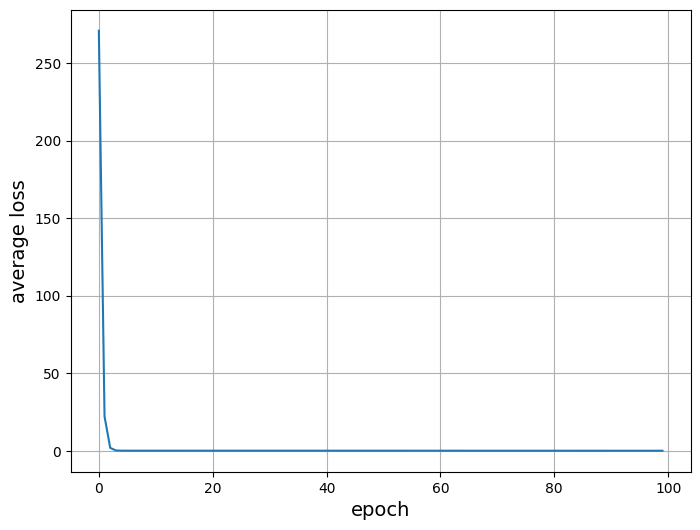

In [11]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()

## Inference

In [12]:
# Purely inference
predicted = model(inputs.requires_grad_()).data.cpu().numpy()

print(predicted[0:10])
print(y[0:10])

[[ 1.2200048]
 [ 3.188322 ]
 [ 5.156639 ]
 [ 7.1249566]
 [ 9.093274 ]
 [11.061591 ]
 [13.029908 ]
 [14.998226 ]
 [16.966543 ]
 [18.93486  ]]
tensor([[ 1.],
        [ 3.],
        [ 5.],
        [ 7.],
        [ 9.],
        [11.],
        [13.],
        [15.],
        [17.],
        [19.]])


## Visualization

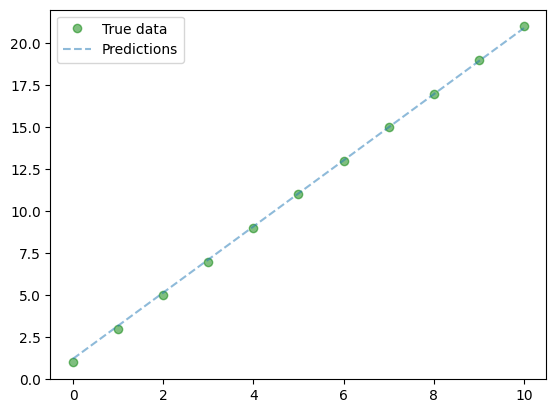

In [13]:
# Clear figure
plt.clf()

# Get predictions
predicted = model(inputs.requires_grad_()).cpu().data.numpy()

# Plot true data
plt.plot(x.detach().cpu(), y.detach().cpu(), 'go', label='True data', alpha=0.5)

# Plot predictions
plt.plot(x.detach().cpu(), predicted, '--', label='Predictions', alpha=0.5)

# Legend and plot
plt.legend(loc='best')
plt.show()

## Print the model weights

In [14]:
print({name: param.data for name, param in model.named_parameters()})

{'linear.weight': tensor([[1.9683]], device='cuda:0'), 'linear.bias': tensor([1.2200], device='cuda:0')}


## Logistic regression


* We have two categories, so the output of the network should be a single value between 0 and 1, which is the estimated probability $p$ for an example to belong to category 1. Then, the probability to belong to category 0 is simply $1-p$. Therefore, we should have a single output neuron, the only neuron in the network.

The sigmoid function can be used in the output neuron. Indeed, it spits out a value between 0 and 1, and can be used as a classification probability as we have seen in the previous section.

We can represent our network in the following way:

![Neural network with 1 neuron](Images/Image2.png)

In the output neuron: 

* the first box performs a change of variable and computes the **weighted input** $z$ of the neuron
* the second box applies the **activation function** to the weighted input. Here, we choose the sigmoid $\sigma (z) = 1/(1+e^{-z})$ as an activation function

This simple network has only 2 tunable parameters, the weight $w$ and the bias $b$, both used in the first box. We see in particular that when the bias is very large, the neuron will **always be activated**, whatever the input. On the contrary, for very negative biases, the neuron is **dead**. 

We can write the output simply as a function of $x$, 

$$f(x) = \sigma(z) = \sigma(wx+b)$$
This is exactly the **logistic regression** classifier.

### The data

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [15]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

## XOR data example
  * Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
  * The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.

### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [16]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

## Creating the XOR dataset

In [17]:
import torch
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([-0.1041,  1.0064]), tensor(1))


## Visualization

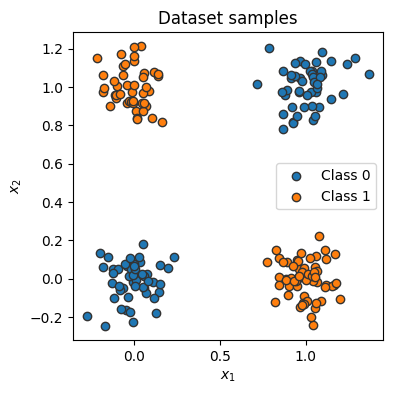

In [18]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
visualize_samples(dataset.data, dataset.label)
plt.show()

## The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity. 
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [19]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [20]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.8669,  1.0811],
        [ 0.0330,  0.0898],
        [ 0.9704,  0.1360],
        [ 0.8181, -0.1213],
        [ 1.0314, -0.1977],
        [-0.0224,  0.0510],
        [ 0.9290, -0.0121],
        [ 0.8943, -0.0825]])
Data labels torch.Size([8]) 
 tensor([0, 0, 1, 1, 1, 0, 1, 1])


## Creating Class Model

In [21]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_outputs)
        self.output = nn.Sigmoid()

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.output(x)

        return x
    
model = SimpleClassifier(num_inputs=2, num_outputs=1)
# Push model to device. Has to be only done once
model = model.to(device)

# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=1, bias=True)
  (output): Sigmoid()
)


## Setting-up the optimizer

In [22]:

# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

In [23]:
# Import accuracy function
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Creat the data
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Setting the loss function (objective function)
criterion = nn.MSELoss()

# Set the output threshold
TH = 0.5

# Set the number of epochs
num_epochs = 100

# Set model to train mode
model.train()

# Training loop
for epoch in tqdm(range(num_epochs)):
    for data_inputs, data_labels in data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = criterion(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
        
        ## Step 6: Estimate the accuracy
        y_pred = np.where(preds.detach().cpu().numpy() > TH, 1, 0)


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.66it/s]


## Visualization the prediction

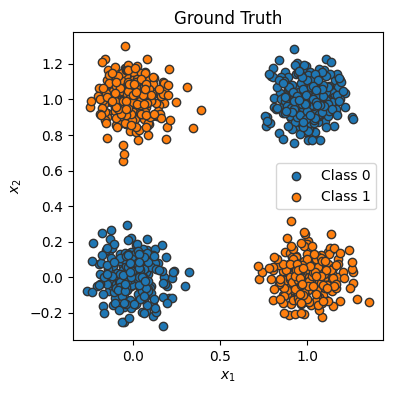

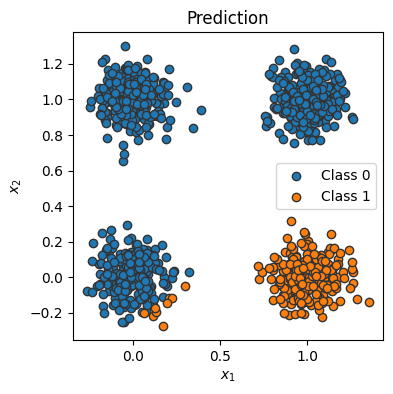

Acuraccy is: 0.735


In [24]:
with torch.no_grad():
    a_train = model(train_dataset.data.to(device))
    y_pred = np.where(a_train.detach().cpu().numpy() > TH, 1, 0)

    
visualize_samples(train_dataset.data, train_dataset.label)
plt.title('Ground Truth')
plt.show()
visualize_samples(train_dataset.data, y_pred[:,0])
plt.title('Prediction')
plt.show()

acc = accuracy_score(train_dataset.label.cpu(), y_pred[:,0])
print('Acuraccy is:', acc)

## How to Solve?